# LAB 5 - Deep Computer Vision (Multiclass CNNs) using Pytorch for Dermatology
The objective of this lab is to understand the fundamentals of convolutional neural networks before approaching other deep learning architectures

#### Project Info

 ->Copyright 2024 Luis R Soenksen

 ->Last Update: March 24, 2024

```
**Licensed under the Apache License, Version 2.0**
You may not use this file except in compliance with the License. You may obtain a copy of the License at
https://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.
```

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Compatible with Google Colab</a>      
    </td>
  <td>
    <a target="_blank" href="https://github.com/lrsoenksen/"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />Visit my GitHub</a>
  </td>
  <td>
    <a href="https://pytorch.org"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/c6/PyTorch_logo_black.svg/488px-PyTorch_logo_black.svg.png" width="150px"/>Built with Pytorch </a>
  </td>
</table>

------------------------------------------------------

### **Step 0) Setup system and import required packages**

In [1]:
!pip install medmnist
!pip install torchmetrics


[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
# Deep learning packages
import torch
import torch.nn as nn
from torch import utils
from torch import optim
from torch import device
from torch import inference_mode
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchmetrics import ConfusionMatrix

# Data management and Plotting
import numpy
import tqdm
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from textwrap import wrap
from timeit import default_timer as timer
import mlxtend
from mlxtend.plotting import plot_confusion_matrix

# Import MedMNIST
import medmnist
from medmnist import INFO, Evaluator
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


In [3]:
# Get CPU or GPU device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
device

device(type='cpu')

### **Step 1) Load data**
**Dataset of Dermoscopy skin diseases**

MedMNIST, is a large-scale MNIST-like collection of standardized biomedical images, including 12 datasets for 2D and 6 datasets for 3D. All images are pre-processed into 28x28 (2D) or 28x28x28 (3D) with the corresponding classification labels, so that no background knowledge is required for users. Covering primary data modalities in biomedical images, MedMNIST is designed to perform classification on lightweight 2D and 3D images with various data scales (from 100 to 100,000) and diverse tasks (binary/multi-class, ordinal regression and multi-label). The resulting dataset, consisting of approximately 708K 2D images and 10K 3D images in total, could support numerous research and educational purposes in biomedical image analysis, computer vision and machine learning. We benchmark several baseline methods on MedMNIST, including 2D / 3D neural networks and open-source / commercial AutoML tools. This example allows you to explore building models for most applications in MedMNIST.

For this specific example we will first use DermMNIST Data Modality is Dermatoscope, which is a Multi-Class (7) dermatology disease identification task with a good Number of Samples: 10,015 provided in the publication Philipp Tschandl, Cliff Rosendahl, et al., "The ham10000 dataset, a large collection of multisource dermatoscopic images of common pigmented skin lesions," Scientific data, vol. 5, pp. 180161, 2018. Noel Codella, Veronica Rotemberg, et al., “Skin Lesion Analysis Toward Melanoma Detection 2018: A Challenge Hosted by the International Skin Imaging Collaboration (ISIC)”, 2018, arXiv:1902.03368.


![overview.jpg](https://medmnist.com/assets/v2/imgs/overview.jpg)



Motivation:

*   To reduce the burden for expert dermatologists in resource-constrained regions and improve diagnostic accuracy.


Inputs:
*   Dermatoscopic images (10,015) across 7 classes of benighnand mal,ignant lesions from the HAM10000 dataset.


Outputs:
*   Clinical dictamination


References:

1.   Philipp Tschandl, Cliff Rosendahl, et al., "The ham10000 dataset, a large collection of multisource dermatoscopic images of common pigmented skin lesions," Scientific data, vol. 5, pp. 180161, 2018.

2.   Noel Codella, Veronica Rotemberg, et al., “Skin Lesion Analysis Toward Melanoma Detection 2018: A Challenge Hosted by the International Skin Imaging Collaboration (ISIC)”, 2018, arXiv:1902.03368.


In [4]:
## Download and Split Datasets
data_flag = 'dermamnist'

# Other possible data to use
# data_flag = 'pathmnist'
# data_flag = 'chestmnist'
# data_flag = 'dermamnist'
# data_flag = 'octmnist'
# data_flag = 'pneumoniamnist'
# data_flag = 'retinamnist'
# data_flag = 'breastmnist'
# data_flag = 'bloodmnist'
# data_flag = 'tissuemnist'
# data_flag = 'organamnist'
# data_flag = 'organcmnist'
# data_flag = 'organsmnist'

# Get data info
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# Number of image channels
n_channels = info['n_channels']
print(f"number of channels: {n_channels}")

# Number of classes
n_classes = len(info['label'])
print(f"number of classes: {n_classes}")

# Number of hidden neurons in model
hidden_units = 128
print(f"number of hidden units: {hidden_units}")

# Get the class names from the dataset
class_names = info['label']
print(f"class names: {class_names}")

# Transform to feed to NN
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
    ])

# Data split
train_data = DataClass(split='train', transform=data_transform, download=True)
val_data = DataClass(split='val', transform=data_transform, download=True)
test_data = DataClass(split='test', transform=data_transform, download=True)

# Data into dataloader form
BATCH_SIZE = 128
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)

number of channels: 3
number of classes: 7
number of hidden units: 128
class names: {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}
Using downloaded and verified file: /Users/sq/.medmnist/dermamnist.npz
Using downloaded and verified file: /Users/sq/.medmnist/dermamnist.npz
Using downloaded and verified file: /Users/sq/.medmnist/dermamnist.npz


In [5]:
# Display characteristics of data
train_data, test_data, val_data
print(train_data)
print("===================")
print(test_data)
print("===================")
print(val_data)
print("===================")

Dataset DermaMNIST of size 28 (dermamnist)
    Number of datapoints: 7007
    Root location: /Users/sq/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}
    Number of samples: {'train': 7007, 'val': 1003, 'test': 2005}
    Description: The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.
    License: CC BY-NC 4.0
Dataset DermaMNIST of size 28 (dermamnist)
    Number of datapoints:

In [6]:
# check dataloader
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of val dataloader: {len(val_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x2848e2650>, <torch.utils.data.dataloader.DataLoader object at 0x2849063d0>)
Length of train dataloader: 55 batches of 128
Length of test dataloader: 16 batches of 128
Length of val dataloader: 8 batches of 128


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

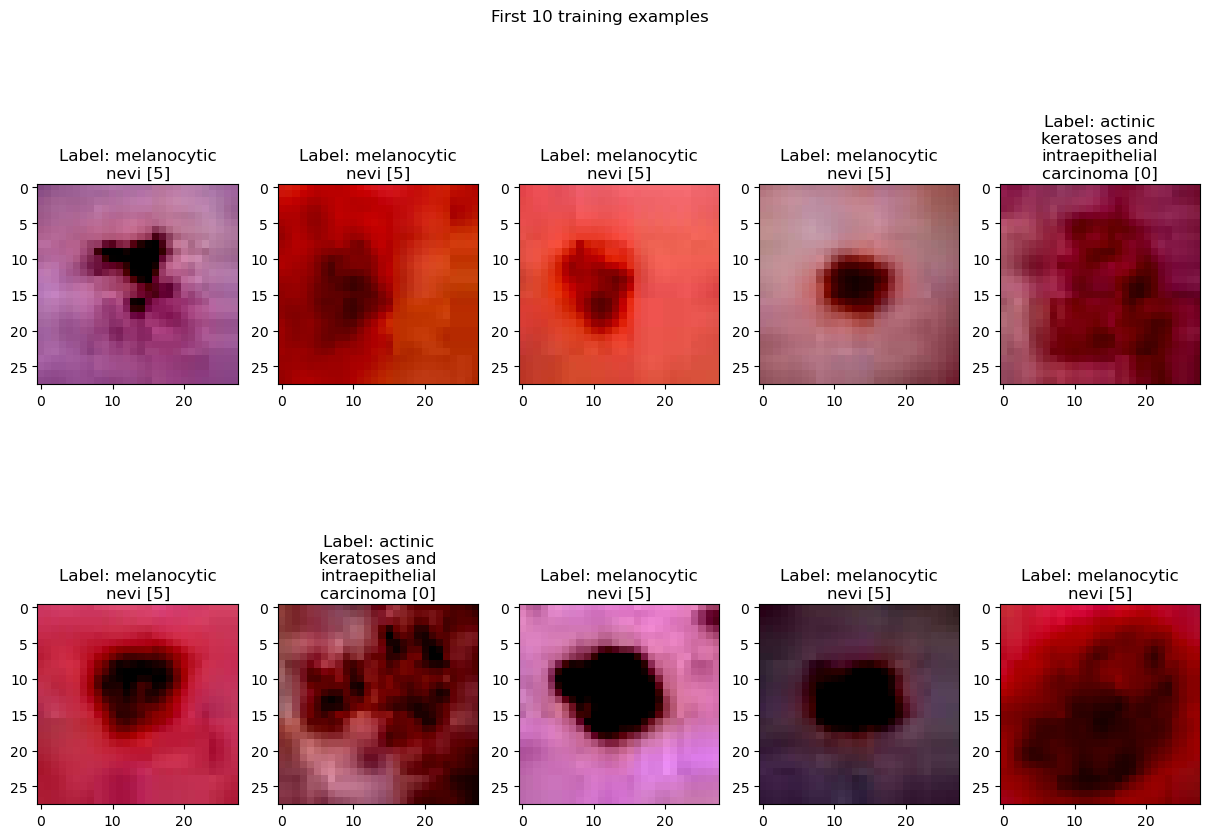

In [7]:
# Plot some data samples with labels
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15, 10))
axs = axs.ravel()

# Iterate through images in train dataloader
i = 0
while i < len(axs):
  images, labels = next(iter(train_dataloader))
  axs[i].imshow(images[0].permute(1, 2, 0).numpy())
  axs[i].set_title("\n".join(wrap(f"Label: {class_names[str(labels[0].item())]}"+ " [" + str(labels[0].item())+ "]", 20)), wrap=True)
  i += 1

plt.suptitle(f"First {len(axs)} training examples")
plt.show()

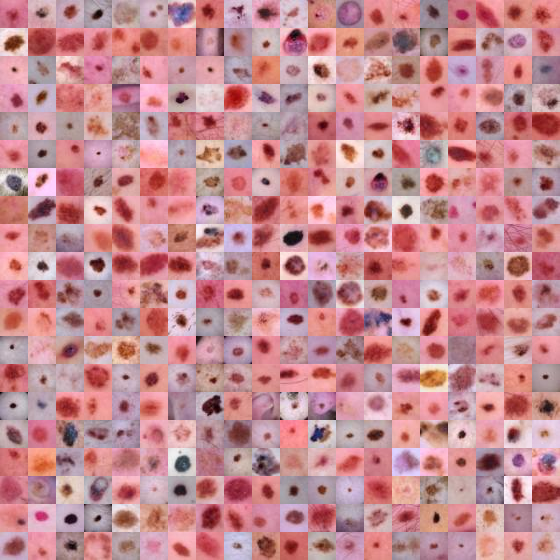

In [8]:
# Show montage of all types of images
train_data.montage(length=20)

### **Step 2) Define and Train Model**

In [9]:
## Making the CNN
class cnn(torch.nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()

        # Layer 1: Conv layer with BatchNorm and ReLU 
        #TO DO
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                        out_channels=hidden_units,
                        kernel_size=3),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU()
        )
        

        # Layer 2: Another Conv layer followed by BatchNorm, ReLU, and MaxPooling
        #TO DO
        self.layer2 = nn.Sequential(
            nn.Conv2d(hidden_units,
                    hidden_units * 2,
                    kernel_size=3),
            nn.BatchNorm2d(hidden_units * 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Layer 3: Conv layer with 4x more filters, followed by BatchNorm and ReLU
        #TO DO
        self.layer3 = nn.Sequential(
            nn.Conv2d(hidden_units * 2,
                    hidden_units * 4,
                    kernel_size=3),
            nn.BatchNorm2d(hidden_units * 4),
            nn.ReLU()
        )

        # Layer 4: Similar Conv layer followed by BatchNorm and ReLU
        #TO DO
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units*4,
                        out_channels=hidden_units*4,
                        kernel_size=3),
            nn.BatchNorm2d(hidden_units*4),
            nn.ReLU()
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units*4,
                      out_channels=hidden_units*4,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(hidden_units*4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2))

        self.fc = nn.Sequential(
            nn.Linear(hidden_units*4 * 4 * 4, hidden_units*8),
            nn.ReLU(),
            nn.Linear(hidden_units*8, hidden_units*8),
            nn.ReLU(),
            nn.Linear(hidden_units*8, n_classes))

    def forward(self, x): #TO DO complete the code for a forward pass
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        #flatten the output of the last conv layer
        x = torch.flatten(x,1)
        #pass the output through the fully connected layer                       
        x = self.fc(x)
        print(x.shape)                    
        return x

# Define Model and send to selected device
#TO DO
model = cnn(n_channels, hidden_units, n_classes).to(device)

# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# View Model
model

cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer5): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e

In [10]:
'''
Fill the in the missing code marked as # TO DO
'''
# Define training loop functions
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):

    train_loss, train_acc = 0, 0
    model.to(device)

    for batch, (X, y) in enumerate(data_loader):
        # need to change target shape for this medmnist data
        y = y.squeeze().long()

        # Send data to selected device
        X, y = X.to(device), y.to(device)  #TO DO
        # 1. Forward pass
        y_pred = model(X)                  #TO DO

        # 2. loss and accuracy
        loss = loss_fn(y_pred, y)          #TO DO
        train_loss += loss.item()          #TO DO
        train_acc += accuracy_fn(y_pred.argmax(dim=1), y) #TO DO

        # 3. Set gradients to zero for next iteration
        optimizer.zero_grad()
                                           #TO DO

        # 4. Compute gradients
        loss.backward()
                                           #TO DO

        # 5. Update parameters
        optimizer.step()
                                           #TO DO

    # Calculate loss and accuracy per epoch
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    return train_loss, train_acc

In [11]:
'''
Fill the in the missing code marked as # TO DO
'''
# Define test loop functions
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):

    test_loss, test_acc = 0, 0
    model.to(device)

    model.eval() # eval mode for testing
    with torch.inference_mode(): # Inference context manager
        for X, y in data_loader:
            # need to change target shape for this medmnist data
            y = y.squeeze().long()

            # Send data to selected device
            X, y = X.to(device), y.to(device)
                                                #TO DO

            # 1. Forward pass
            y_pred = model(X)
                                                #TO DO

            # 2. Calculate loss and accuracy
            #TO DO
            test_loss += loss_fn(y_pred, y)                       
            #TO DO
            test_acc += accuracy_fn(y_pred.argmax(dim=1), y)                      

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

        return test_loss, test_acc

In [18]:
'''
Fill the in the missing code marked as # TO DO
'''
# Define evaluation loop functions
def eval_func(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):

    eval_loss, eval_acc = 0, 0
    model.to(device)

    model.eval()
    y_preds = []
    y_targets = []
    with torch.inference_mode():
        for batch, (X, y) in tqdm(enumerate(data_loader)):
            # need to change target shape for this medmnist data
            y = y.squeeze().long()

            # Send data to selected device
            X, y =  X.to(device), y.to(device)        #TO DO

            # Forward pass
            eval_pred = model(X)                        #TO DO

            # Find loss and accuracy
            eval_loss += loss_fn(eval_pred, y)           #TO DO
            eval_acc += accuracy_fn(eval_pred.argmax(dim=1), y)  #TO DO


            # Add prediction and target labels to list
            eval_labels = torch.argmax(eval_pred, dim=1)   #TO DO
            y_preds.append(eval_labels)
            y_targets.append(y)

        # Scale loss and acc
        eval_loss /= len(data_loader)
        eval_acc /= len(data_loader)

        # Put predictions on CPU for evaluation
        y_preds=torch.cat(y_preds).cpu()
        y_targets=torch.cat(y_targets).cpu()

        return {"model_name": model.__class__.__name__,
                "loss": eval_loss.item(),
                "accuracy": eval_acc,
                "predictions": y_preds,
                "targets": y_targets}

In [13]:
# Function to calculate model run time
def print_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [14]:
# Accuracy calculation function
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [15]:
## Train and Test

# Set random seeds
torch.manual_seed(42)

# Measure Time
train_time_start_model = timer()
iteration_loss_list = []
iteration_accuracy_list = []

# set parameters
epochs = 10
best_loss = 10

# call train and test function
for epoch in tqdm(range(epochs)):
    #TO DO
    train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, accuracy_fn, device=device)
    
    #TO DO
    test_loss, test_acc = test_step(test_dataloader, model, loss_fn, accuracy_fn, device=device)

    for iteration, (x, y) in enumerate(train_dataloader):
        iteration_loss_list.append(train_loss)
        iteration_accuracy_list.append(train_acc)


    print(f"Epoch: {epoch} | Training loss: {train_loss:.3f} | Training acc: {train_acc:.2f} | Test loss: {test_loss:.3f} | Test acc: {test_acc:.2f}")

    # save best model instance

    if test_loss < best_loss:
        best_loss = test_loss
        print(f"Saving best model for epoch: {epoch}")
        torch.save(obj=model.state_dict(),
                   f="./model.pth")


train_time_end_model = timer()
total_train_time_model = print_train_time(start=train_time_start_model,
                                           end=train_time_end_model,
                                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([1

In [19]:
## Evaluate and visualize results

# Load model
loaded_model = cnn(input_shape=n_channels,
                   hidden_units=hidden_units,
                   output_shape=n_classes).to(device)

loaded_model.load_state_dict(torch.load(f="./model.pth"))

# get results
#call eval_func  #TO DO
model_results = eval_func(test_dataloader, loaded_model, loss_fn, accuracy_fn, device=device)                  

model_results
# points for accuracy more than 70%

0it [00:00, ?it/s]

torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([128, 7])
torch.Size([85, 7])


{'model_name': 'cnn',
 'loss': 0.6699864268302917,
 'accuracy': 75.04423253676471,
 'predictions': tensor([5, 5, 4,  ..., 5, 2, 4]),
 'targets': tensor([5, 5, 4,  ..., 5, 3, 5])}

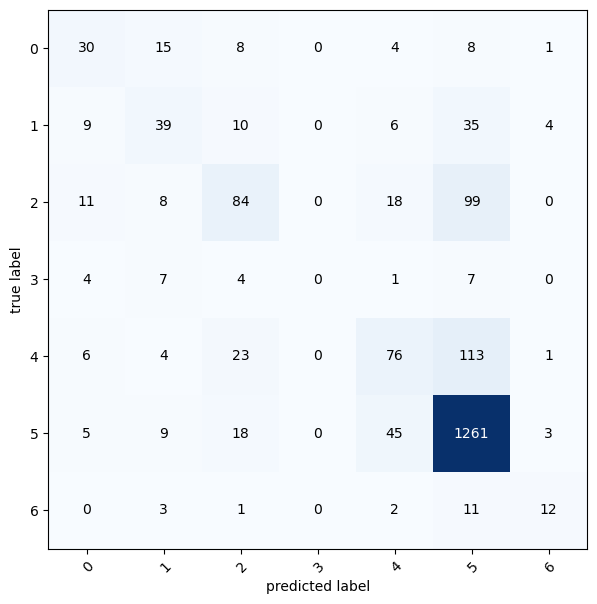

In [20]:
# Get Model predictions and true targets
y_targets = model_results['targets']
y_preds = model_results['predictions']

# Setup confusion matrix
confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
confmat_tensor = confmat(preds=y_preds,
                         target=y_targets)

# Plot the confusion matrix
fix, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
)

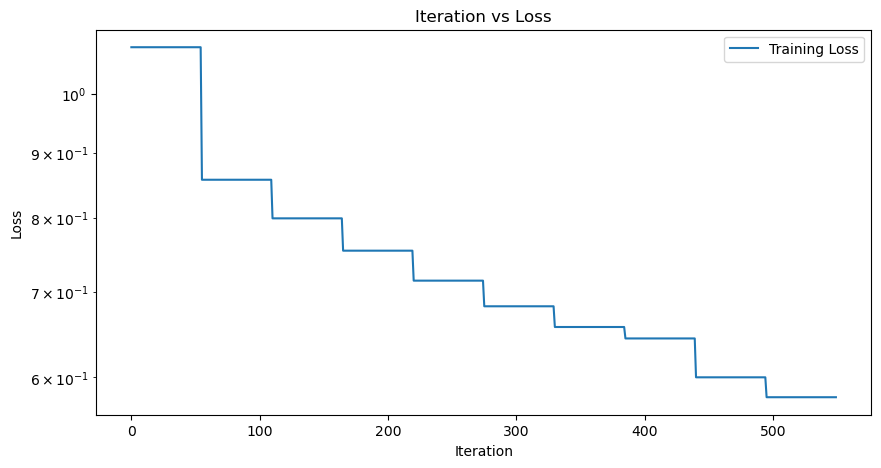

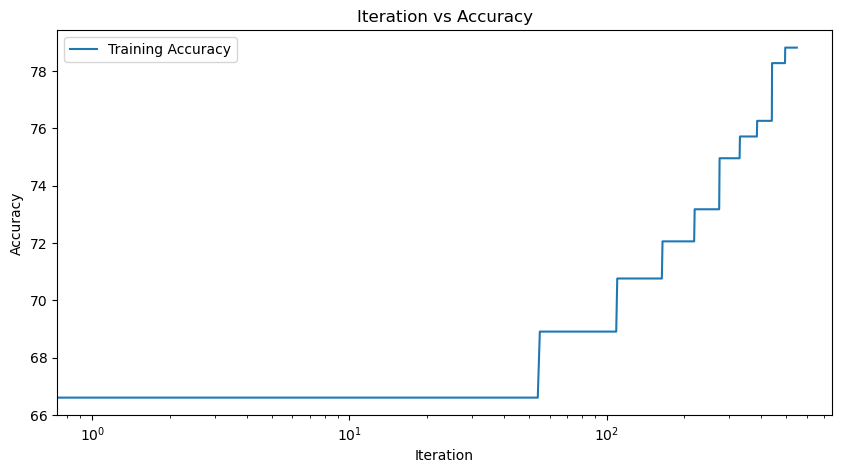

In [21]:
# Plot iteration vs loss
plt.figure(figsize=(10, 5))
plt.semilogy(iteration_loss_list, label='Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Iteration vs Loss')
plt.legend()
plt.show()

# Plot iteration vs accuracy
plt.figure(figsize=(10, 5))
plt.semilogx(iteration_accuracy_list, label='Training Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Iteration vs Accuracy')
plt.legend()
plt.show()

### **Step 3) Run inference on new data**

In [22]:
torch.save(loaded_model.state_dict(), "medmnist_cnn_pytorch.ckpt")

In [28]:
def visualize_and_predict(model, device, data_loader):
    model.eval()
    with torch.no_grad():
        # Extract the first batch of images and labels
        data, target = next(iter(data_loader))
        # Select the first image and label
        img, label = data[0], target[0]

        # Visualize the image
        plt.imshow(img.permute(1, 2, 0).numpy())
        plt.title(f"\n".join(wrap(f"Actual Label: {class_names[str(label.item())]}"+ " [" + str(label.item())+ "]", 20)))
        plt.show()

        # Run inference
        img = img.unsqueeze(0) #TO DO
        output = model(img.to(device)) #TO DO # Add batch dimension
        pred = output.argmax(dim=1) #TO DO

        print(f"\n".join(wrap(f"Predicted Label: {class_names[str(pred.item())]}"+ " [" + str(pred.item())+ "]", 20)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


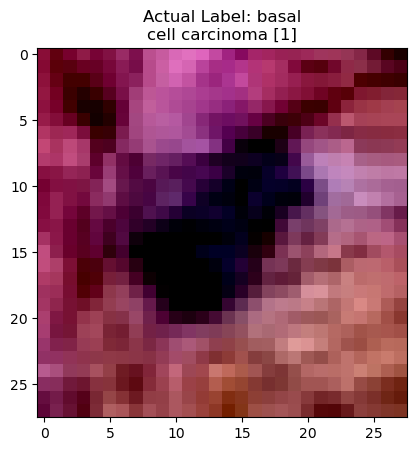

torch.Size([1, 7])
Predicted Label:
vascular lesions [6]


In [29]:
visualize_and_predict(loaded_model, device, test_dataloader)

------------------------------------------------------
------------------------------------------------------